## Finding Spurious Correlations in Image Datasets

In this tutorial, we demonstrate the impact of training a model on a dataset with spurious correlations, focusing on a scenario where one class consists predominantly of dark images. We then compare the model's performance on a dataset free from such spurious correlations.

Finally, we showcase how `Datalab` can effortlessly detect spuriously correlated features, such as darkness or blurriness, with class labels. The `lab.report()` function further highlights the most extreme instances of these correlations, identified during the execution of `lab.find_issues()`.

Please install the dependencies specified in [requirements.txt](https://github.com/cleanlab/examples/blob/master/spurious_correlations_datalab/requirements.txt) file before running the notebook.
To fetch the data for this tutorial, make sure you have `wget` and `zip` installed.

In [ ]:
# Download the dataset
!wget -nc https://s.cleanlab.ai/Food-101-subset.zip
!unzip -q Food-101-subset.zip

In [2]:
# Import libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

#### Loading datasets for Image Classification

In [3]:
# setting seed for reproducibility
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

# transformation to make sure the image size is consistent with the model architecture
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# using spuriously correlated dataset for training (darkened 'chicken_wings' images)
spurious_train_dataset = datasets.ImageFolder(root='Food-101-subset/train_darkened', transform=transform)
validation_dataset = datasets.ImageFolder(root='Food-101-subset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Food-101-subset/test', transform=transform)

# Extract the class to index mapping
class_to_idx = spurious_train_dataset.class_to_idx
class_to_idx

{'chicken_wings': 0, 'french_fries': 1}

In [4]:
# preparing dataloader objects for each of the training, validation and test dataset
batch_size = 4
spurious_trainloader = DataLoader(spurious_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
# Function to display images with their corresponding class names using subplots
def imshow(images, labels):
    class_names = [list(class_to_idx.keys())[list(class_to_idx.values()).index(label)] for label in labels]
    num_images = len(images)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    if num_images == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        npimg = images[i].numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(class_names[i])
        ax.axis('off')
    
    plt.show()

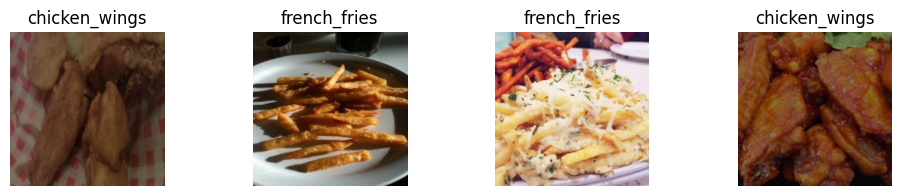

In [6]:
# Get some random training images with darkened 'chicken_wings' images
dataiter = iter(spurious_trainloader)
images, labels = next(dataiter)

# Show images with class names
imshow(images, labels)

Notice 'darker' `chicken_wings` images

#### Defining the architecture of the model

In [7]:
# defining CNN architecture parameters for image classification
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_classes = 2
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=200704, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=self.num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# function that returns the 'trained' parameters on 'trainloader'
def train_network(net, trainloader, validationloader, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)  # L2 regularization (weight decay)
    net.to(device)
    best_val_accuracy = 0.0
    best_model_wts = net.state_dict()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 1000 == 0:
                print(f'Epoch={epoch} Iter={i} Loss={loss.item():.3f}')
        
        net.eval()
        val_accuracy = accuracy(net, validationloader)
        print(f'Epoch={epoch} Validation Accuracy={val_accuracy:.2f}%')
        
        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            print("Updating the best model state")
            best_val_accuracy = val_accuracy
            best_model_wts = net.state_dict().copy()
    
    # Load best model weights
    net.load_state_dict(best_model_wts)
    print('Finished Training')
    return net

def accuracy(net, testloader):
    running_accuracy = 0
    running_count = 0
    for images, labels in iter(testloader):
        images = images.to(device)
        predictions = net(images.to(device)).argmax(axis=1).cpu().detach()
        accuracy = (labels==predictions).double().mean()

        running_accuracy += accuracy
        running_count += 1
    return 100 * running_accuracy / running_count

#### Training on dataset that has Spurious Correlations with the class labels

In [8]:
best_net = train_network(Net(), trainloader=spurious_trainloader, validationloader=validationloader, n_epochs=10)

Epoch=0 Iter=0 Loss=0.692
Epoch=0 Validation Accuracy=50.00%
Updating the best model state
Epoch=1 Iter=0 Loss=0.317
Epoch=1 Validation Accuracy=51.97%
Updating the best model state
Epoch=2 Iter=0 Loss=0.314
Epoch=2 Validation Accuracy=51.32%
Epoch=3 Iter=0 Loss=0.315
Epoch=3 Validation Accuracy=53.95%
Updating the best model state
Epoch=4 Iter=0 Loss=0.313
Epoch=4 Validation Accuracy=53.29%
Epoch=5 Iter=0 Loss=0.314
Epoch=5 Validation Accuracy=51.32%
Epoch=6 Iter=0 Loss=0.452
Epoch=6 Validation Accuracy=53.95%
Epoch=7 Iter=0 Loss=0.313
Epoch=7 Validation Accuracy=50.66%
Epoch=8 Iter=0 Loss=0.314
Epoch=8 Validation Accuracy=54.61%
Updating the best model state
Epoch=9 Iter=0 Loss=0.313
Epoch=9 Validation Accuracy=52.63%
Finished Training


In [9]:
# Finding accuracy on the test dataset with no spurious correlations
acc = accuracy(best_net, testloader)
print(f"Accuracy on the dataset where the training images were darkened for 'chicken_wings class' = {acc:.2f}")

Accuracy on the dataset where the training images were darkened for 'chicken_wings class' = 52.63


#### Loading the training dataset that has no Spurious Correlations with the class labels

In [10]:
# Using the same validation and test datasets, but with a training dataset that has no spurious correlations.
# That is both the classes 'chicken_wings' and 'french_fries' have no 'darkened_images'
train_dataset = datasets.ImageFolder(root='Food-101-subset/train', transform=transform)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

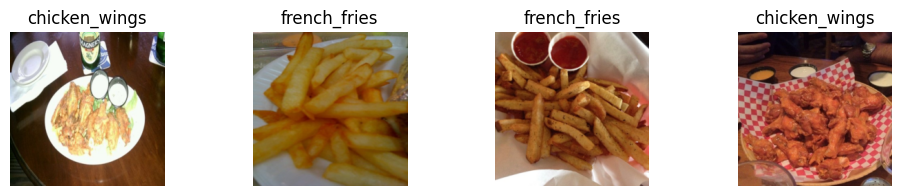

In [11]:
# get some random training images (with no spurious correlations)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)

#### Training on dataset that has no Spurious Correlations with the class labels

In [12]:
best_net_no_correlations = train_network(Net(), trainloader=trainloader, validationloader=validationloader, n_epochs=10)

Epoch=0 Iter=0 Loss=0.707
Epoch=0 Validation Accuracy=61.84%
Updating the best model state
Epoch=1 Iter=0 Loss=0.704
Epoch=1 Validation Accuracy=64.47%
Updating the best model state
Epoch=2 Iter=0 Loss=0.367
Epoch=2 Validation Accuracy=68.42%
Updating the best model state
Epoch=3 Iter=0 Loss=0.559
Epoch=3 Validation Accuracy=69.74%
Updating the best model state
Epoch=4 Iter=0 Loss=0.742
Epoch=4 Validation Accuracy=71.05%
Updating the best model state
Epoch=5 Iter=0 Loss=0.576
Epoch=5 Validation Accuracy=73.03%
Updating the best model state
Epoch=6 Iter=0 Loss=0.472
Epoch=6 Validation Accuracy=71.05%
Epoch=7 Iter=0 Loss=0.329
Epoch=7 Validation Accuracy=69.08%
Epoch=8 Iter=0 Loss=0.371
Epoch=8 Validation Accuracy=66.45%
Epoch=9 Iter=0 Loss=0.348
Epoch=9 Validation Accuracy=75.00%
Updating the best model state
Finished Training


In [13]:
# Finding accuracy when trained on a training datset with no spurious correlations

acc = accuracy(best_net_no_correlations, testloader)
print(f"Accuracy on the train dataset with no spurious correlations = {acc:.2f}")

Accuracy on the train dataset with no spurious correlations = 72.37


#### Key Takeaway

By comparing these two experiments, it’s clear how important it is to train models on data without spurious correlations. In the second experiment (training on dataset with no spurious correlations), the model learned the right features and performed well. But in the first experiment, the introduction of spurious correlations (the darkness) caused the model to make mistakes. It’s like teaching someone that all dogs are brown—if they see a white dog, they might not recognize it as a dog at all. This is why it’s crucial to avoid misleading information in your training data so the model can generalize and perform well on new, real-world data.

### Detecting issues using Cleanlab

In [14]:
from cleanlab import Datalab
from datasets import Dataset
from torchvision.datasets import ImageFolder

def load_image_dataset(data_dir: str):
    """
    Load images from a directory structure and create a datasets.Dataset object.
    
    Parameters
    ----------
    data_dir : str
        Path to the root directory containing class subdirectories.
    
    Returns
    -------
    datasets.Dataset
        A Dataset object containing 'image' and 'label' columns.
    """
    image_dataset = ImageFolder(data_dir)
    images = [img for img, _ in image_dataset]
    labels = [label for _, label in image_dataset]
    return Dataset.from_dict({"image": images, "label": labels})

# Running Datalab from Cleanlab on the training data having darkened images of the 'chicken_wings' class
darkened_correlated_dataset = load_image_dataset('Food-101-subset/train_darkened')
darkened_correlated_lab = Datalab(darkened_correlated_dataset, label_name="label", image_key="image")
darkened_correlated_lab.find_issues()

/home/cgptuser01/Desktop/rahul/sense_vectors/cleanlab/ENV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finding class_imbalance issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


100%|██████████| 400/400 [03:46<00:00,  1.77it/s]


Finding spurious correlation issues in the dataset ...

Audit complete. 11 issues found in the dataset.


#### Finding label-uncorrelatedness scores of image properties with class labels

In [15]:
darkened_label_uncorrelatedness_scores = darkened_correlated_lab.get_info("spurious_correlations")["correlations_df"]
darkened_label_uncorrelatedness_scores

,property,score
0,odd_size_score,0.5150
1,odd_aspect_ratio_score,0.4650
2,low_information_score,0.0900
3,light_score,0.2200
4,grayscale_score,0.5000
5,dark_score,0.0325
6,blurry_score,0.3875


The label-uncorrelatedness score for dark images, i.e. `dark_score`, is significantly smaller (0.0325) which tells us that there is a much higher correlation between dark image property and class labels. This is because the `chicken_wings` class has darker images while the `french_fries` class has brighter images.

#### Generating detailed analysis using `lab.report()`

Dataset Information: num_examples: 400, num_classes: 2

Here is a summary of various issues found in your data:

issue_type  num_issues
    blurry           8
      dark           3

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.






---------------------- blurry images -----------------------

Number of examples with this issue: 8
Examples representing most severe instances of this issue:



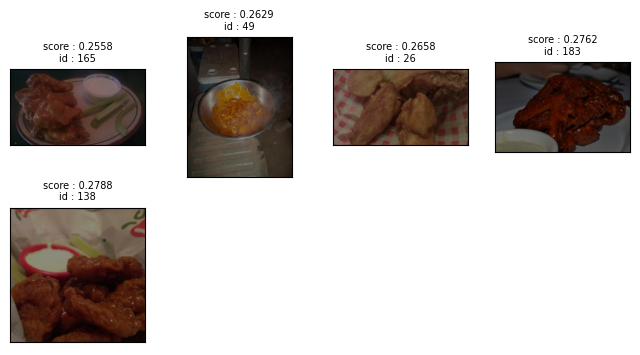

----------------------- dark images ------------------------

Number of examples with this issue: 3
Examples representing most severe instances of this issue:



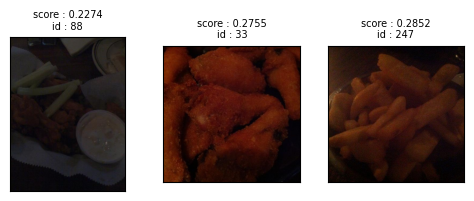




Summary of (potentially spurious) correlations between image properties and class labels detected in the data:

Lower scores below correspond to images properties that are more strongly correlated with the class labels.


property  score
    dark 0.0325

Here are the images corresponding to the extreme (minimum and maximum) individual scores for each of the detected correlated properties:


Images with minimum and maximum individual scores for dark issue:



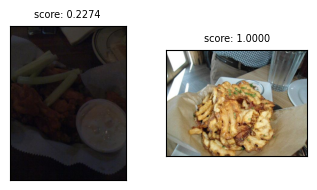

In [16]:
darkened_correlated_lab.report()

The section on Spurious Correlations shows which properties are highly correlated with the class labels and the extreme instances in the dataset to show disparity.

#### Running `Datalab` on the dataset with no spurious correlations

In [17]:
# Running Datalab from Cleanlab on the original dataset (no spurious correlations)
dataset = load_image_dataset('Food-101-subset/train')
lab = Datalab(data=dataset, label_name="label", image_key="image")
lab.find_issues()

Finding class_imbalance issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


100%|██████████| 400/400 [04:08<00:00,  1.61it/s]


Finding spurious correlation issues in the dataset ...

Audit complete. 2 issues found in the dataset.


In [18]:
label_uncorrelatedness_scores = lab.get_info("spurious_correlations")["correlations_df"]
label_uncorrelatedness_scores

,property,score
0,odd_size_score,0.5150
1,odd_aspect_ratio_score,0.4650
2,low_information_score,0.4825
3,light_score,0.3775
4,grayscale_score,0.5000
5,dark_score,0.4575
6,blurry_score,0.4550


Dataset Information: num_examples: 400, num_classes: 2

Here is a summary of various issues found in your data:

issue_type  num_issues
      dark           1
    blurry           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.






----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



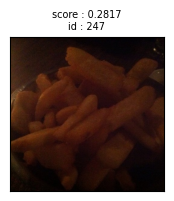

---------------------- blurry images -----------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



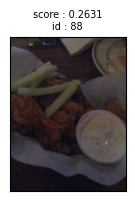

In [19]:
lab.report()

Notice that `lab.report()` has no section on Spurious Correlations because all the image property scores are much higher.